# PRE-PROCESSING

In [8]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy all edf files to same place for easier conversion to ascii
""" source_folder = "/Users/dako/Downloads/VISCOM/all_pro_saccade"  # Change this to your actual source folder path
destination_folder = "/Users/dako/Desktop/Viscom_all_participants/Reactions/pro_edf"  # Change this to your actual destination folder path

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Iterate over subfolders and copy .edf files
for root, _, files in os.walk(source_folder):
    for file in files:
        if file.endswith(".EDF"):
            source_file = os.path.join(root, file)
            destination_file = os.path.join(destination_folder, file)
            
            # Ensure unique filenames if multiple subfolders have same file name
            if os.path.exists(destination_file):
                filename, ext = os.path.splitext(file)
                counter = 1
                while os.path.exists(os.path.join(destination_folder, f"{filename}_{counter}{ext}")):
                    counter += 1
                destination_file = os.path.join(destination_folder, f"{filename}_{counter}{ext}")

            shutil.copy2(source_file, destination_file)  # Preserve metadata
            print(f"Copied: {source_file} -> {destination_file}")

print("All .edf files have been copied successfully.") """

' source_folder = "/Users/dako/Downloads/VISCOM/all_pro_saccade"  # Change this to your actual source folder path\ndestination_folder = "/Users/dako/Desktop/Viscom_all_participants/Reactions/pro_edf"  # Change this to your actual destination folder path\n\n# Ensure the destination folder exists\nos.makedirs(destination_folder, exist_ok=True)\n\n# Iterate over subfolders and copy .edf files\nfor root, _, files in os.walk(source_folder):\n    for file in files:\n        if file.endswith(".EDF"):\n            source_file = os.path.join(root, file)\n            destination_file = os.path.join(destination_folder, file)\n            \n            # Ensure unique filenames if multiple subfolders have same file name\n            if os.path.exists(destination_file):\n                filename, ext = os.path.splitext(file)\n                counter = 1\n                while os.path.exists(os.path.join(destination_folder, f"{filename}_{counter}{ext}")):\n                    counter += 1\n         

In [9]:
# Load the participant info Excel file
file_path = "/Users/dako/Downloads/VISCOM/info (1).xlsx"  
df = pd.read_excel(file_path)

In [10]:
def process_file_trials(file_path):
    """
    Process a single ASC file to extract trial events for the reactions condition.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    events = []
    current_trial_id = None  # Keep track of the current trial ID

    # Parse the lines
    for line in lines:
        line = line.strip()

        # Detect trial start marked by "TRIALID"
        if "TRIALID" in line:
            current_trial_id = int(line.split()[-1])  # Update current trial ID
            time = int(line.split()[1])  # Extract time
            events.append({
                "trial_id": current_trial_id,
                "time": time,
                "event": "TRIALID",
                "stimulus_x": None,
                "stimulus_y": None,
                "delay": None,
                "colour": None
            })

        # Detect START line, marking the beginning of the trial
        elif line.startswith("START"):
            time = int(line.split()[1])  # Extract time
            events.append({
                "trial_id": current_trial_id,
                "time": time,
                "event": "START",
                "stimulus_x": None,
                "stimulus_y": None,
                "delay": None,
                "colour": None
            })

        # Detect END line, marking the end of the trial
        elif line.startswith("END"):
            time = int(line.split()[1])  # Extract time
            events.append({
                "trial_id": current_trial_id,
                "time": time,
                "event": "END",
                "stimulus_x": None,
                "stimulus_y": None,
                "delay": None,
                "colour": None
            })

        # Detect "!V TRIAL_VAR_DATA"
        elif "!V TRIAL_VAR_DATA" in line:
            parts = line.split()
            try:
                time = int(parts[1])  # Extract time
                stimulus_x = float(parts[4])  # X position of stimulus
                stimulus_y = float(parts[5])  # Y position of stimulus
                delay = float(parts[6])  # Delay in seconds
            except (ValueError, IndexError):
                stimulus_x = None
                stimulus_y = None
                delay = None
            events.append({
                "trial_id": current_trial_id,
                "time": time if 'time' in locals() else None,
                "event": "TRIAL_VAR_DATA",
                "stimulus_x": stimulus_x,
                "stimulus_y": stimulus_y,
                "delay": delay,
                "colour": None
            })

        # Detect FIXPOINT messages
        elif "FIXPOINT" in line:
            parts = line.split()
            try:
                time = int(parts[1])  # Extract time
                colour = " ".join(parts[4:7])  # Extract first 3 values after FIXPOINT
            except (ValueError, IndexError):
                colour = None
            events.append({
                "trial_id": current_trial_id,
                "time": time if 'time' in locals() else None,
                "event": "FIXPOINT",
                "stimulus_x": float(parts[10]),
                "stimulus_y": float(parts[11]),
                "delay": None,
                "colour": colour
            })

    # Convert events to a DataFrame
    events_df = pd.DataFrame(events)
    events_df = events_df.sort_values(by=["trial_id", "time"]).reset_index(drop=True)
    return events_df

# Process multiple files
data_directory = '/Users/dako/Desktop/Viscom_all_participants/Reactions/pro_edf'  # Replace with your directory path
all_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.asc')]

combined_df = pd.DataFrame()

for file_path in all_files:
    events_df = process_file_trials(file_path)
    events_df['file_name'] = os.path.basename(file_path)  # Add file identifier
    combined_df = pd.concat([combined_df, events_df], ignore_index=True)

# Extract participant ID and save combined DataFrame
combined_df['participant_id'] = combined_df['file_name'].str.extract(r'Reaction_(\d+)_')
combined_df['participant_id'] = combined_df['participant_id'].astype(int)
# Rename values in the 'event' column
combined_df.loc[combined_df["event"] == "FIXPOINT", "event"] = combined_df.apply(
    lambda row: "stimulus_onset" if row["colour"] == "255 0 0" else row["event"], axis=1
)

trial_data = combined_df.drop(columns=['file_name'])
trial_data['condition'] = trial_data['participant_id'].map(df.set_index('ID')['Group'])

In [12]:
trial_data = trial_data.sort_values(by=["participant_id", "trial_id"]).reset_index(drop=True)
print(trial_data.to_string()) 

       trial_id      time           event  stimulus_x  stimulus_y      delay       colour  participant_id condition
0           0.0   2213061         TRIALID         NaN         NaN        NaN         None             103   PATIENT
1           0.0   2213068           START         NaN         NaN        NaN         None             103   PATIENT
2           0.0   2218913  TRIAL_VAR_DATA         NaN         NaN        NaN         None             103   PATIENT
3           0.0   2219017             END         NaN         NaN        NaN         None             103   PATIENT
4           1.0   2225097         TRIALID         NaN         NaN        NaN         None             103   PATIENT
5           1.0   2225104           START         NaN         NaN        NaN         None             103   PATIENT
6           1.0   2230747  TRIAL_VAR_DATA         NaN         NaN        NaN         None             103   PATIENT
7           1.0   2230850             END         NaN         NaN       

In [ ]:
trial_data = pd.read_csv('/Users/dako/Desktop/Viscom_all_participants/Reactions/reactions_all_trials.csv')


       trial_id      time           event  stimulus_x  stimulus_y      delay       colour  participant_id condition
0           0.0   2116363         TRIALID         NaN         NaN        NaN          NaN             267   PATIENT
1           0.0   2116381           START         NaN         NaN        NaN          NaN             267   PATIENT
2           0.0   2116424        FIXPOINT       960.0       540.0        NaN  255 255 255             267   PATIENT
3           0.0   2116949  stimulus_onset       295.0       207.0        NaN      255 0 0             267   PATIENT
4           0.0   2117951  TRIAL_VAR_DATA       295.0       207.0   0.523528          NaN             267   PATIENT
5           0.0   2118054             END         NaN         NaN        NaN          NaN             267   PATIENT
6           1.0   2123132         TRIALID         NaN         NaN        NaN          NaN             267   PATIENT
7           1.0   2123156           START         NaN         NaN       

In [5]:
trial_data.to_csv("reactions_all_trials.csv", index=False)

In [6]:
# Define the directory containing ASC files
asc_directory = '/Users/dako/Desktop/Viscom_all_participants/Reactions/pro_edf'

# List all ASC files in the directory
asc_files = [f for f in os.listdir(asc_directory) if f.endswith('.asc')]

# Display the files to confirm
print("Files to process:", asc_files)

Files to process: ['Reaction_267_0.asc', 'Reaction_243_1.asc', 'Reaction_387_0.asc', 'Reaction_347_0.asc', 'Reaction_281_2.asc', 'Reaction_283_0.asc', 'Reaction_182_0.asc', 'Reaction_206_0.asc', 'Reaction_142_0.asc', 'Reaction_105_0.asc', 'Reaction_204_0.asc', 'Reaction_239_0.asc', 'Reaction_180_0.asc', 'Reaction_138_0.asc', 'Reaction_345_0.asc', 'Reaction_302_2.asc', 'Reaction_258_0.asc', 'Reaction_199_0.asc', 'Reaction_220_0.asc', 'Reaction_298_0.asc', 'Reaction_121_0.asc', 'Reaction_378_0.asc', 'Reaction_219_0.asc', 'Reaction_118_0.asc', 'Reaction_339_0.asc', 'Reaction_125_0.asc', 'Reaction_358_0.asc', 'Reaction_200_0.asc', 'Reaction_245_0.asc', 'Reaction_381_1.asc', 'Reaction_144_0.asc', 'Reaction_285_0.asc', 'Reaction_278_0.asc', 'Reaction_184_0.asc', 'Reaction_365_0.asc', 'Reaction_398_0.asc', 'Reaction_322_0.asc', 'Reaction_103_0.asc', 'Reaction_146_0.asc', 'Reaction_383_0.asc', 'Reaction_263_0.asc', 'Reaction_127_0.asc', 'Reaction_343_0.asc', 'Reaction_325_0.asc', 'Reaction_141

In [7]:
def parse_metadata(filename):
    """
    Extract metadata (e.g., participant ID, condition) from a filename.
    Assumes filename structure: participantID_condition_XXX.asc.
    """
    # Remove the file extension
    base = os.path.splitext(filename)[0]
    
    # Split the base name into components (assuming underscores separate variables)
    parts = base.split('_')
    
    # Adjust indices according to your naming convention
    participant_id = parts[1]
    condition = parts[0] if len(parts) > 1 else 'unknown'
    
    return participant_id, condition

# Example usage
for file in asc_files:
    pid, cond = parse_metadata(file)
    print(f"File: {file} -> Participant ID: {pid}, Condition: {cond}")

File: Reaction_267_0.asc -> Participant ID: 267, Condition: Reaction
File: Reaction_243_1.asc -> Participant ID: 243, Condition: Reaction
File: Reaction_387_0.asc -> Participant ID: 387, Condition: Reaction
File: Reaction_347_0.asc -> Participant ID: 347, Condition: Reaction
File: Reaction_281_2.asc -> Participant ID: 281, Condition: Reaction
File: Reaction_283_0.asc -> Participant ID: 283, Condition: Reaction
File: Reaction_182_0.asc -> Participant ID: 182, Condition: Reaction
File: Reaction_206_0.asc -> Participant ID: 206, Condition: Reaction
File: Reaction_142_0.asc -> Participant ID: 142, Condition: Reaction
File: Reaction_105_0.asc -> Participant ID: 105, Condition: Reaction
File: Reaction_204_0.asc -> Participant ID: 204, Condition: Reaction
File: Reaction_239_0.asc -> Participant ID: 239, Condition: Reaction
File: Reaction_180_0.asc -> Participant ID: 180, Condition: Reaction
File: Reaction_138_0.asc -> Participant ID: 138, Condition: Reaction
File: Reaction_345_0.asc -> Partic

In [8]:
def process_file(file_path, participant_id, condition):
    """
    Process a single ASC file to extract fixations, saccades, and trials,
    including detailed trial event data like stimulus onset.
    Handles malformed lines by filling missing or invalid values with NaN.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize containers
    fixations = []
    saccades = []
    events = []
    current_trial_id = None  # Keep track of the current trial ID

    # Parse the lines
    for line in lines:
        line = line.strip()

        # Fixations
        if line.startswith("EFIX"):
            parts = line.split()
            fixations.append({
                "trial_id": current_trial_id,
                "eye": parts[1] if len(parts) > 1 else np.nan,
                "start_time": int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else np.nan,
                "end_time": int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else np.nan,
                "duration": int(parts[4]) if len(parts) > 4 and parts[4].isdigit() else np.nan,
                "x": float(parts[5]) if len(parts) > 5 and parts[5].replace('.', '', 1).isdigit() else np.nan,
                "y": float(parts[6]) if len(parts) > 6 and parts[6].replace('.', '', 1).isdigit() else np.nan,
                "avg_pupil_size": float(parts[7]) if len(parts) > 7 and parts[7].replace('.', '', 1).isdigit() else np.nan,
                "participant_id": participant_id,
                "condition": condition,
            })

        # Saccades
        elif line.startswith("ESACC"):
            parts = line.split()
            saccades.append({
                "trial_id": current_trial_id,
                "eye": parts[1] if len(parts) > 1 else np.nan,
                "start_time": int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else np.nan,
                "end_time": int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else np.nan,
                "duration": int(parts[4]) if len(parts) > 4 and parts[4].isdigit() else np.nan,
                "start_x": float(parts[5]) if len(parts) > 5 and parts[5].replace('.', '', 1).isdigit() else np.nan,
                "start_y": float(parts[6]) if len(parts) > 6 and parts[6].replace('.', '', 1).isdigit() else np.nan,
                "end_x": float(parts[7]) if len(parts) > 7 and parts[7].replace('.', '', 1).isdigit() else np.nan,
                "end_y": float(parts[8]) if len(parts) > 8 and parts[8].replace('.', '', 1).isdigit() else np.nan,
                "amplitude": float(parts[9]) if len(parts) > 9 and parts[9].replace('.', '', 1).isdigit() else np.nan,
                "peak_velocity": float(parts[10]) if len(parts) > 10 and parts[10].replace('.', '', 1).isdigit() else np.nan,
                "participant_id": participant_id,
                "condition": condition,
            })

        # Trial events
        elif "TRIALID" in line:
            current_trial_id = int(line.split()[-1])  # Update current trial ID
            time = int(line.split()[1])  # Extract time
            events.append({"trial_id": current_trial_id, "time": time, "event": "TRIALID", "colour": None, "coordinates": None})


    # Convert to DataFrames for fixations and saccades
    fixations_df = pd.DataFrame(fixations)
    saccades_df = pd.DataFrame(saccades)

    return fixations_df, saccades_df

In [9]:
fixations_list = []
saccades_list = []
trials_list = []

for file in asc_files:
    file_path = os.path.join(asc_directory, file)
    participant_id, condition = parse_metadata(file)
    
    fixations_df, saccades_df = process_file(file_path, participant_id, condition)
    
    fixations_list.append(fixations_df)
    saccades_list.append(saccades_df)
    #trials_list.append(trials_df)

# Combine all data into single DataFrames
all_fixations = pd.concat(fixations_list, ignore_index=True)
all_saccades = pd.concat(saccades_list, ignore_index=True)
#all_trials = pd.concat(trials_list, ignore_index=True)

In [10]:
filtered_fixations = all_fixations[(all_fixations["duration"] >= 140) & (all_fixations["duration"] <= 800)]
filtered_saccades = all_saccades[(all_saccades["duration"] >= 5) & (all_saccades["duration"] <= 100)]
filtered_saccades = filtered_saccades[(filtered_saccades["amplitude"] > 0.4) & (filtered_saccades["peak_velocity"] > 0)]
filtered_saccades["average_velocity"] = filtered_saccades["amplitude"] / filtered_saccades["duration"]*1000

In [11]:
filtered_fixations['participant_id'] = filtered_fixations['participant_id'].astype(int)
filtered_saccades['participant_id'] = filtered_saccades['participant_id'].astype(int)

/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_37526/3094471635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fixations['participant_id'] = filtered_fixations['participant_id'].astype(int)


In [14]:
filtered_fixations['condition'] = filtered_fixations['participant_id'].map(df.set_index('ID')['Group'])
filtered_saccades['condition'] = filtered_saccades['participant_id'].map(df.set_index('ID')['Group'])

/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_37526/3254084167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fixations['condition'] = filtered_fixations['participant_id'].map(df.set_index('ID')['Group'])


In [15]:
# Define the directory containing the subfolders
directory_path = "/Users/dako/Downloads/VISCOM/all_pro_saccade"

# Get all subfolder names (assuming they are numbers)
subfolders = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]

# Convert folder names to integers
subfolder_numbers = set(map(int, subfolders))

# Convert participant_id list to a set of integers
comparison_numbers = set(map(int, trial_data['participant_id'].unique()))

# Find differences
only_in_subfolders = subfolder_numbers - comparison_numbers
only_in_comparison = comparison_numbers - subfolder_numbers

# Print results
print("Folders not in the comparison list:", only_in_subfolders)
print("Numbers not found as folders:", only_in_comparison)

Folders not in the comparison list: set()
Numbers not found as folders: set()


In [16]:
len(np.unique(filtered_fixations['participant_id']))

178

In [17]:
filtered_fixations.to_csv("reactions_all_fixations.csv", index=False)
filtered_saccades.to_csv("reactions_all_saccades.csv", index=False)
#trial_data.to_csv("reactions_all_trials.csv", index=False)

In [18]:
stimulus_onset_df = trial_data[trial_data["event"] == "stimulus_onset"]

In [20]:
def determine_stim_direction(row):
    if row["stimulus_x"] < 960.0 and row["stimulus_y"] < 540.0:
        return "left_down"
    elif row["stimulus_x"] < 960.0 and row["stimulus_y"] > 540.0:
        return "left_up"
    elif row["stimulus_x"] > 960.0 and row["stimulus_y"] < 540.0:
        return "right_down"
    elif row["stimulus_x"] > 960.0 and row["stimulus_y"] > 540.0:
        return "right_up"
    elif row["stimulus_x"] == 960.0 and row["stimulus_y"] < 540.0:
        return "down"
    elif row["stimulus_x"] == 960.0 and row["stimulus_y"] > 540.0:
        return "up"
    elif row["stimulus_x"] < 960.0 and row["stimulus_y"] == 540.0:
        return "left"
    elif row["stimulus_x"] > 960.0 and row["stimulus_y"] == 540.0:
        return "right"
    else:
        return "center"  # If exactly at (960.0, 540.0)

stimulus_onset_df["stim_direction"] = stimulus_onset_df.apply(determine_stim_direction, axis=1)


# Display the updated DataFrame
(stimulus_onset_df.reset_index(drop=True))

/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_37526/3471920149.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_onset_df["stim_direction"] = stimulus_onset_df.apply(determine_stim_direction, axis=1)


trial_id     time           event  stimulus_x  stimulus_y  delay  \
0          0.0  2116949  stimulus_onset       295.0       207.0    NaN   
1          1.0  2128354  stimulus_onset       960.0       229.0    NaN   
2          2.0  2138150  stimulus_onset      1270.0       540.0    NaN   
3          3.0  2153291  stimulus_onset       295.0       207.0    NaN   
4          4.0  2171041  stimulus_onset       915.0       495.0    NaN   
...        ...      ...             ...         ...         ...    ...   
4051      19.0  4270235  stimulus_onset      1624.0       207.0    NaN   
4052      20.0  4285074  stimulus_onset       960.0       229.0    NaN   
4053      21.0  4289703  stimulus_onset      1181.0       318.0    NaN   
4054      22.0  4304604  stimulus_onset      1624.0       872.0    NaN   
4055      23.0  4321114  stimulus_onset      1624.0       207.0    NaN   

       colour  participant_id condition stim_direction  
0     255 0 0             267   PATIENT      left_down  
1     255 0 0             267   PATIENT           down  
2     255 0 0             267   PATIENT          right  
3     255 0 0             267   PATIENT      left_down  
4     255 0 0             267   PATIENT      left_down  
...       ...             ...       ...            ...  
4051  255 0 0             333   PATIENT     right_down  
4052  255 0 0             333   PATIENT           down  
4053  255 0 0             333   PATIENT     right_down  
4054  255 0 0             333   PATIENT       right_up  
4055  255 0 0             333   PATIENT     right_down  

[4056 rows x 10 columns]

In [26]:
len(np.unique(trial_data['participant_id']))

178

In [22]:
# Summarize the number of unique trial IDs per participant
trial_summary2 = stimulus_onset_df.groupby("participant_id")["trial_id"].nunique().reset_index()

# Rename columns for clarity
trial_summary2.columns = ["participant_id", "unique_trial_count"]
print(trial_summary2.to_string())

     participant_id  unique_trial_count
0               106                  24
1               111                  24
2               125                  24
3               128                  72
4               133                  24
5               134                  24
6               135                  24
7               137                  24
8               138                  24
9               141                  24
10              142                  24
11              143                  24
12              144                  24
13              146                  24
14              147                  24
15              149                  24
16              150                  24
17              151                  24
18              152                  24
19              153                  24
20              156                  24
21              157                  24
22              169                  24
23              171                  24


In [23]:
# Split stim_direction into stim_direction_x and stim_direction_y
stimulus_onset_df["stim_direction_x"] = stimulus_onset_df["stim_direction"].apply(
    lambda d: "left" if "left" in d else "right" if "right" in d else None
)

stimulus_onset_df["stim_direction_y"] = stimulus_onset_df["stim_direction"].apply(
    lambda d: "up" if "up" in d else "down" if "down" in d else None
)

# Display the updated DataFrame
(stimulus_onset_df)

/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_37526/2112507250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_onset_df["stim_direction_x"] = stimulus_onset_df["stim_direction"].apply(
/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_37526/2112507250.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_onset_df["stim_direction_y"] = stimulus_onset_df["stim_direction"].apply(


trial_id     time           event  stimulus_x  stimulus_y  delay  \
3           0.0  2116949  stimulus_onset       295.0       207.0    NaN   
9           1.0  2128354  stimulus_onset       960.0       229.0    NaN   
15          2.0  2138150  stimulus_onset      1270.0       540.0    NaN   
21          3.0  2153291  stimulus_onset       295.0       207.0    NaN   
27          4.0  2171041  stimulus_onset       915.0       495.0    NaN   
...         ...      ...             ...         ...         ...    ...   
24711      19.0  4270235  stimulus_onset      1624.0       207.0    NaN   
24717      20.0  4285074  stimulus_onset       960.0       229.0    NaN   
24723      21.0  4289703  stimulus_onset      1181.0       318.0    NaN   
24729      22.0  4304604  stimulus_onset      1624.0       872.0    NaN   
24735      23.0  4321114  stimulus_onset      1624.0       207.0    NaN   

        colour  participant_id condition stim_direction stim_direction_x  \
3      255 0 0             267   PATIENT      left_down             left   
9      255 0 0             267   PATIENT           down             None   
15     255 0 0             267   PATIENT          right            right   
21     255 0 0             267   PATIENT      left_down             left   
27     255 0 0             267   PATIENT      left_down             left   
...        ...             ...       ...            ...              ...   
24711  255 0 0             333   PATIENT     right_down            right   
24717  255 0 0             333   PATIENT           down             None   
24723  255 0 0             333   PATIENT     right_down            right   
24729  255 0 0             333   PATIENT       right_up            right   
24735  255 0 0             333   PATIENT     right_down            right   

      stim_direction_y  
3                 down  
9                 down  
15                None  
21                down  
27                down  
...                ...  
24711             down  
24717             down  
24723             down  
24729               up  
24735             down  

[4056 rows x 12 columns]

In [30]:
filtered_saccades = filtered_saccades.dropna(subset=["trial_id"])
filtered_saccades["participant_id"] = filtered_saccades["participant_id"].astype(int)
filtered_saccades["trial_id"] = filtered_saccades["trial_id"].astype(int)

In [33]:
def determine_saccade_direction(row):
    if row["end_x"] < 960.0 and row["end_y"] < 540.0:
        return "left_down"
    elif row["end_x"] < 960.0 and row["end_y"] > 540.0:
        return "left_up"
    elif row["end_x"] > 960.0 and row["end_y"] < 540.0:
        return "right_down"
    elif row["end_x"] > 960.0 and row["end_y"] > 540.0:
        return "right_up"
    elif row["end_x"] == 960.0 and row["end_y"] < 540.0:
        return "down"
    elif row["end_x"] == 960.0 and row["end_y"] > 540.0:
        return "up"
    elif row["end_x"] < 960.0 and row["end_y"] == 540.0:
        return "left"
    elif row["end_x"] > 960.0 and row["end_y"] == 540.0:
        return "right"
    else:
        return "center"  # If exactly at (960.0, 540.0)

filtered_saccades["saccade_direction"] = filtered_saccades.apply(determine_saccade_direction, axis=1)
# Split stim_direction into stim_direction_x and stim_direction_y
filtered_saccades["saccade_direction_x"] = filtered_saccades["saccade_direction"].apply(
    lambda d: "left" if "left" in d else "right" if "right" in d else None
)

filtered_saccades["saccade_direction_y"] = filtered_saccades["saccade_direction"].apply(
    lambda d: "up" if "up" in d else "down" if "down" in d else None
)

filtered_saccades['condition'] = filtered_saccades['participant_id'].map(df.set_index('ID')['Group'])
# Display the updated DataFrame
(filtered_saccades)

trial_id eye  start_time  end_time  duration  start_x  start_y   end_x  \
0             0   L     2117178   2117231        53    990.4    570.4   338.4   
1             0   R     2117180   2117234        54    955.7    586.1   315.7   
2             0   L     2117438   2117448        10    329.7    246.1   293.8   
3             0   R     2117437   2117454        17    324.0    262.3   265.3   
4             1   R     2128605   2128650        45    948.4    568.3   958.6   
...         ...  ..         ...       ...       ...      ...      ...     ...   
67102        23   R     4321318   4321380        62    984.8    524.4  1615.8   
67103        23   L     4321555   4321578        23   1611.6    201.8  1678.8   
67104        23   R     4321553   4321582        29   1596.2    218.4  1650.3   
67105        23   R     4321746   4321761        15   1654.2    207.5  1594.9   
67106        23   L     4321744   4321766        22   1661.5    184.3  1607.5   

       end_y  amplitude  peak_velocity  participant_id condition  \
0      244.3      13.13          396.0             267   PATIENT   
1      264.9      12.90          390.0             267   PATIENT   
2      243.8       0.64           65.0             267   PATIENT   
3      253.8       1.05           87.0             267   PATIENT   
4      230.6       6.12          228.0             267   PATIENT   
...      ...        ...            ...             ...       ...   
67102  206.5      12.75          490.0             333   PATIENT   
67103  165.3       1.36          137.0             333   PATIENT   
67104  197.9       1.03          144.0             333   PATIENT   
67105  205.6       1.05           92.0             333   PATIENT   
67106  181.2       0.96          106.0             333   PATIENT   

       average_velocity saccade_direction saccade_direction_x  \
0            247.735849         left_down                left   
1            238.888889         left_down                left   
2             64.000000         left_down                left   
3             61.764706         left_down                left   
4            136.000000         left_down                left   
...                 ...               ...                 ...   
67102        205.645161        right_down               right   
67103         59.130435        right_down               right   
67104         35.517241        right_down               right   
67105         70.000000        right_down               right   
67106         43.636364        right_down               right   

      saccade_direction_y  
0                    down  
1                    down  
2                    down  
3                    down  
4                    down  
...                   ...  
67102                down  
67103                down  
67104                down  
67105                down  
67106                down  

[32477 rows x 17 columns]

In [34]:
stimulus_onset_df["participant_id"] = stimulus_onset_df["participant_id"].astype(int)
stimulus_onset_df["trial_id"] = stimulus_onset_df["trial_id"].astype(int)

merged_df = pd.merge(
    filtered_saccades,
    stimulus_onset_df[["participant_id", "trial_id", "time", "stim_direction","stim_direction_x", "stim_direction_y"]],
    on=["participant_id", "trial_id"],
    suffixes=("", "_stimulus")
)[
    filtered_saccades.columns.tolist() + ["time", "stim_direction","stim_direction_x", "stim_direction_y"]
]

# Ensure saccade_direction is retained
(merged_df)

/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_37526/241743267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_onset_df["participant_id"] = stimulus_onset_df["participant_id"].astype(int)
/var/folders/rd/94hjv6z13s11fzgrxgmvpt3r0000gn/T/ipykernel_37526/241743267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_onset_df["trial_id"] = stimulus_onset_df["trial_id"].astype(int)


trial_id eye  start_time  end_time  duration  start_x  start_y   end_x  \
0             0   L     2117178   2117231        53    990.4    570.4   338.4   
1             0   R     2117180   2117234        54    955.7    586.1   315.7   
2             0   L     2117438   2117448        10    329.7    246.1   293.8   
3             0   R     2117437   2117454        17    324.0    262.3   265.3   
4             1   R     2128605   2128650        45    948.4    568.3   958.6   
...         ...  ..         ...       ...       ...      ...      ...     ...   
32010        23   R     4321318   4321380        62    984.8    524.4  1615.8   
32011        23   L     4321555   4321578        23   1611.6    201.8  1678.8   
32012        23   R     4321553   4321582        29   1596.2    218.4  1650.3   
32013        23   R     4321746   4321761        15   1654.2    207.5  1594.9   
32014        23   L     4321744   4321766        22   1661.5    184.3  1607.5   

       end_y  amplitude  ...  participant_id  condition average_velocity  \
0      244.3      13.13  ...             267    PATIENT       247.735849   
1      264.9      12.90  ...             267    PATIENT       238.888889   
2      243.8       0.64  ...             267    PATIENT        64.000000   
3      253.8       1.05  ...             267    PATIENT        61.764706   
4      230.6       6.12  ...             267    PATIENT       136.000000   
...      ...        ...  ...             ...        ...              ...   
32010  206.5      12.75  ...             333    PATIENT       205.645161   
32011  165.3       1.36  ...             333    PATIENT        59.130435   
32012  197.9       1.03  ...             333    PATIENT        35.517241   
32013  205.6       1.05  ...             333    PATIENT        70.000000   
32014  181.2       0.96  ...             333    PATIENT        43.636364   

       saccade_direction saccade_direction_x saccade_direction_y     time  \
0              left_down                left                down  2116949   
1              left_down                left                down  2116949   
2              left_down                left                down  2116949   
3              left_down                left                down  2116949   
4              left_down                left                down  2128354   
...                  ...                 ...                 ...      ...   
32010         right_down               right                down  4321114   
32011         right_down               right                down  4321114   
32012         right_down               right                down  4321114   
32013         right_down               right                down  4321114   
32014         right_down               right                down  4321114   

       stim_direction stim_direction_x stim_direction_y  
0           left_down             left             down  
1           left_down             left             down  
2           left_down             left             down  
3           left_down             left             down  
4                down             None             down  
...               ...              ...              ...  
32010      right_down            right             down  
32011      right_down            right             down  
32012      right_down            right             down  
32013      right_down            right             down  
32014      right_down            right             down  

[32015 rows x 21 columns]

In [37]:
valid_saccades = merged_df[merged_df["start_time"] >= merged_df["time"]]
valid_saccades = valid_saccades[(valid_saccades["start_time"] - valid_saccades["time"]) >= 40]
# Group by participant and trial, and select the first saccade
reaction_time = valid_saccades.sort_values(by=["participant_id", "trial_id", "start_time"]).groupby(
    ["participant_id", "trial_id"]
).first().reset_index()

# Rename and retain only relevant columns
reaction_time = reaction_time[[
    "participant_id", "trial_id", "start_time", "time", 'start_x', 'end_x', "end_time", "duration", "amplitude", "peak_velocity", "average_velocity", "stim_direction","saccade_direction"
]].rename(columns={"time": "stimulus_onset_time", "start_time": "first_saccade_start_time"})

# Add the reaction_time column
reaction_time["reaction_time"] = reaction_time["first_saccade_start_time"] - reaction_time["stimulus_onset_time"]
reaction_time['condition'] = reaction_time['participant_id'].map(df.set_index('ID')['Group'])

In [39]:
# Save to CSV or display if needed
reaction_time.to_csv("reactions_all_reaction_times.csv", index=False)

In [40]:
# Create an empty list to store valid rows
valid_rows = []

# Loop through each row in valid_saccades
for _, row in valid_saccades.iterrows():
    # Check for a complete match between saccade_direction and stim_direction
    if row["saccade_direction"] == row["stim_direction"]:
        valid_rows.append(row)
    # Check if saccade_direction_x matches stim_direction_x or saccade_direction_y matches stim_direction_y
    elif (
        (row["saccade_direction_x"] == row["stim_direction_x"]) or
        (row["saccade_direction_y"] == row["stim_direction_y"])
    ):
        valid_rows.append(row)

# Convert the list of valid rows into a DataFrame
reaction_time_correct = pd.DataFrame(valid_rows)

# Sort by participant_id, trial_id, and start_time, then keep only the first saccade per trial
reaction_time_correct = reaction_time_correct.sort_values(
    by=["participant_id", "trial_id", "start_time"]
).groupby(["participant_id", "trial_id"]).first().reset_index()

# Rename and retain only relevant columns
reaction_time_correct = reaction_time_correct[[
    "participant_id", "trial_id", "start_time", "time", "end_time", "duration",
    "start_x", "end_x", "amplitude", "peak_velocity", "average_velocity",
    "saccade_direction", "stim_direction", "saccade_direction_x", "saccade_direction_y",
    "stim_direction_x", "stim_direction_y"
]].rename(columns={"time": "stimulus_onset_time", "start_time": "first_saccade_start_time"})

# Add reaction_time column
reaction_time_correct["reaction_time"] = (
    reaction_time_correct["first_saccade_start_time"] - reaction_time_correct["stimulus_onset_time"]
)

# Sort the DataFrame by participant_id and trial_id
reaction_time_correct = reaction_time_correct.sort_values(by=["participant_id", "trial_id"]).reset_index(drop=True)
reaction_time_correct['condition'] = reaction_time_correct['participant_id'].map(df.set_index('ID')['Group'])

# Display the result
(reaction_time_correct)

participant_id  trial_id  first_saccade_start_time  stimulus_onset_time  \
0                106         0                   1930395              1930092   
1                106         1                   1938930              1938720   
2                106         2                   1943791              1943542   
3                106         3                   1959359              1958742   
4                106         4                   1975203              1974975   
...              ...       ...                       ...                  ...   
3956             404        19                   3247266              3247064   
3957             404        20                   3263475              3263320   
3958             404        21                   3269670              3269492   
3959             404        22                   3285908              3285698   
3960             404        23                   3302932              3302745   

      end_time  duration  start_x   end_x  amplitude  peak_velocity  \
0      1930462        67    954.0   310.4      12.56          320.0   
1      1938970        40    972.3   942.3       4.62          211.0   
2      1943839        48    949.7  1231.2       5.14          286.0   
3      1959373        14    294.8   327.8       0.78           76.0   
4      1975219        16    959.3   909.5       1.03           98.0   
...        ...       ...      ...     ...        ...            ...   
3956   3247343        77   1012.9  1654.6      12.96          451.0   
3957   3263519        44    984.5   971.2       3.57          229.0   
3958   3269718        48    953.7  1175.5       5.53          293.0   
3959   3285970        62   1002.8  1584.1      11.72          406.0   
3960   3302997        65    975.7  1534.7      10.99          412.0   

      average_velocity saccade_direction stim_direction saccade_direction_x  \
0           187.462687         left_down      left_down                left   
1           115.500000         left_down           down                left   
2           107.083333          right_up          right               right   
3            55.714286         left_down      left_down                left   
4            64.375000         left_down      left_down                left   
...                ...               ...            ...                 ...   
3956        168.311688        right_down     right_down               right   
3957         81.136364        right_down           down               right   
3958        115.208333        right_down     right_down               right   
3959        189.032258          right_up       right_up               right   
3960        169.076923        right_down     right_down               right   

     saccade_direction_y stim_direction_x stim_direction_y  reaction_time  \
0                   down             left             down            303   
1                   down             None             down            210   
2                     up            right             None            249   
3                   down             left             down            617   
4                   down             left             down            228   
...                  ...              ...              ...            ...   
3956                down            right             down            202   
3957                down             None             down            155   
3958                down            right             down            178   
3959                  up            right               up            210   
3960                down            right             down            187   

     condition  
0      PATIENT  
1      PATIENT  
2      PATIENT  
3      PATIENT  
4      PATIENT  
...        ...  
3956   CONTROL  
3957   CONTROL  
3958   CONTROL  
3959   CONTROL  
3960   CONTROL  

[3961 rows x 19 columns]

In [41]:
reaction_time_correct.to_csv("reactions_correct_reaction_times.csv", index=False)

In [44]:
filtered_fixations = filtered_fixations.dropna(subset=["trial_id"])

filtered_fixations["participant_id"] = filtered_fixations["participant_id"].astype(int)
filtered_fixations["trial_id"] = filtered_fixations["trial_id"].astype(int)
# Merge filtered_fixations with stimulus_onset_df on participant_id and trial_id
fixations_with_stimulus = pd.merge(
    filtered_fixations,
    stimulus_onset_df[["participant_id", "trial_id", "time", "stim_direction"]],
    on=["participant_id", "trial_id"],
    suffixes=("", "_stimulus")
)

# Filter fixations where start_time is after stimulus onset
fixations_after_stimulus = fixations_with_stimulus[
    fixations_with_stimulus["start_time"] >= fixations_with_stimulus["time"]
]
fixations_after_stimulus = fixations_after_stimulus[(fixations_after_stimulus["start_time"] - fixations_after_stimulus["time"]) >= 50]

# Group by participant and trial and get the first fixation (smallest start_time)
first_fixation_after_stimulus = fixations_after_stimulus.sort_values(
    by=["participant_id", "trial_id", "start_time"]
).groupby(["participant_id", "trial_id"]).first().reset_index()

# Keep relevant columns
first_fixation_after_stimulus = first_fixation_after_stimulus[[
    "participant_id", "trial_id", "start_time", "end_time", "duration", "x", "y", 
    "avg_pupil_size", "time", "stim_direction"
]].rename(columns={"time": "stimulus_onset_time"})

first_fixation_after_stimulus['condition'] = first_fixation_after_stimulus['participant_id'].map(df.set_index('ID')['Group'])

# Display or save the result
(first_fixation_after_stimulus)

participant_id  trial_id  start_time  end_time  duration       x      y  \
0                106         0     1930591   1931195       604   291.3  192.3   
1                106         1     1939067   1939222       155   953.4  224.9   
2                106         2     1943985   1944647       662  1254.3  532.3   
3                106         3     1959136   1959360       224   259.4  248.3   
4                106         4     1975219   1975371       152   914.6  523.3   
...              ...       ...         ...       ...       ...     ...    ...   
3566             404        19     3247345   3247559       214  1655.4  201.4   
3567             404        20     3263648   3264260       612   974.6  243.7   
3568             404        21     3269719   3270007       288  1190.9  342.9   
3569             404        22     3286105   3286801       696  1656.6  884.3   
3570             404        23     3303096   3303505       409  1688.2  232.9   

      avg_pupil_size  stimulus_onset_time stim_direction condition  
0             1377.0              1930092      left_down   PATIENT  
1             1774.0              1938720           down   PATIENT  
2             1298.0              1943542          right   PATIENT  
3             1504.0              1958742      left_down   PATIENT  
4             1437.0              1974975      left_down   PATIENT  
...              ...                  ...            ...       ...  
3566          1288.0              3247064     right_down   CONTROL  
3567           697.0              3263320           down   CONTROL  
3568          1291.0              3269492     right_down   CONTROL  
3569          1231.0              3285698       right_up   CONTROL  
3570           816.0              3302745     right_down   CONTROL  

[3571 rows x 11 columns]

In [45]:
# Calculate the time to first fixation
first_fixation_after_stimulus["time_to_first_fixation"] = (
    first_fixation_after_stimulus["start_time"] - first_fixation_after_stimulus["stimulus_onset_time"]
)

# Display or save the result
(first_fixation_after_stimulus)


participant_id  trial_id  start_time  end_time  duration       x      y  \
0                106         0     1930591   1931195       604   291.3  192.3   
1                106         1     1939067   1939222       155   953.4  224.9   
2                106         2     1943985   1944647       662  1254.3  532.3   
3                106         3     1959136   1959360       224   259.4  248.3   
4                106         4     1975219   1975371       152   914.6  523.3   
...              ...       ...         ...       ...       ...     ...    ...   
3566             404        19     3247345   3247559       214  1655.4  201.4   
3567             404        20     3263648   3264260       612   974.6  243.7   
3568             404        21     3269719   3270007       288  1190.9  342.9   
3569             404        22     3286105   3286801       696  1656.6  884.3   
3570             404        23     3303096   3303505       409  1688.2  232.9   

      avg_pupil_size  stimulus_onset_time stim_direction condition  \
0             1377.0              1930092      left_down   PATIENT   
1             1774.0              1938720           down   PATIENT   
2             1298.0              1943542          right   PATIENT   
3             1504.0              1958742      left_down   PATIENT   
4             1437.0              1974975      left_down   PATIENT   
...              ...                  ...            ...       ...   
3566          1288.0              3247064     right_down   CONTROL   
3567           697.0              3263320           down   CONTROL   
3568          1291.0              3269492     right_down   CONTROL   
3569          1231.0              3285698       right_up   CONTROL   
3570           816.0              3302745     right_down   CONTROL   

      time_to_first_fixation  
0                        499  
1                        347  
2                        443  
3                        394  
4                        244  
...                      ...  
3566                     281  
3567                     328  
3568                     227  
3569                     407  
3570                     351  

[3571 rows x 12 columns]

In [46]:
first_fixation_after_stimulus.to_csv("reactions_first_fixation.csv", index=False)

In [47]:
reaction_time_correct

participant_id  trial_id  first_saccade_start_time  stimulus_onset_time  \
0                106         0                   1930395              1930092   
1                106         1                   1938930              1938720   
2                106         2                   1943791              1943542   
3                106         3                   1959359              1958742   
4                106         4                   1975203              1974975   
...              ...       ...                       ...                  ...   
3956             404        19                   3247266              3247064   
3957             404        20                   3263475              3263320   
3958             404        21                   3269670              3269492   
3959             404        22                   3285908              3285698   
3960             404        23                   3302932              3302745   

      end_time  duration  start_x   end_x  amplitude  peak_velocity  \
0      1930462        67    954.0   310.4      12.56          320.0   
1      1938970        40    972.3   942.3       4.62          211.0   
2      1943839        48    949.7  1231.2       5.14          286.0   
3      1959373        14    294.8   327.8       0.78           76.0   
4      1975219        16    959.3   909.5       1.03           98.0   
...        ...       ...      ...     ...        ...            ...   
3956   3247343        77   1012.9  1654.6      12.96          451.0   
3957   3263519        44    984.5   971.2       3.57          229.0   
3958   3269718        48    953.7  1175.5       5.53          293.0   
3959   3285970        62   1002.8  1584.1      11.72          406.0   
3960   3302997        65    975.7  1534.7      10.99          412.0   

      average_velocity saccade_direction stim_direction saccade_direction_x  \
0           187.462687         left_down      left_down                left   
1           115.500000         left_down           down                left   
2           107.083333          right_up          right               right   
3            55.714286         left_down      left_down                left   
4            64.375000         left_down      left_down                left   
...                ...               ...            ...                 ...   
3956        168.311688        right_down     right_down               right   
3957         81.136364        right_down           down               right   
3958        115.208333        right_down     right_down               right   
3959        189.032258          right_up       right_up               right   
3960        169.076923        right_down     right_down               right   

     saccade_direction_y stim_direction_x stim_direction_y  reaction_time  \
0                   down             left             down            303   
1                   down             None             down            210   
2                     up            right             None            249   
3                   down             left             down            617   
4                   down             left             down            228   
...                  ...              ...              ...            ...   
3956                down            right             down            202   
3957                down             None             down            155   
3958                down            right             down            178   
3959                  up            right               up            210   
3960                down            right             down            187   

     condition  
0      PATIENT  
1      PATIENT  
2      PATIENT  
3      PATIENT  
4      PATIENT  
...        ...  
3956   CONTROL  
3957   CONTROL  
3958   CONTROL  
3959   CONTROL  
3960   CONTROL  

[3961 rows x 19 columns]

# ANALYSIS

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
reaction_time = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Reactions/reactions_all_reaction_times.csv")
reaction_time_correct = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Reactions/reactions_correct_reaction_times.csv")
first_fixation = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Reactions/reactions_first_fixation.csv")
all_saccades = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Reactions/reactions_all_saccades.csv")
all_fixations = pd.read_csv("/Users/dako/Desktop/Viscom_all_participants/Reactions/reactions_all_fixations.csv")

In [3]:
# List of participant IDs to exclude
excluded_participants = [103, 105, 109, 113, 117, 118, 119, 120, 121, 122, 127]

# Exclude rows where participant_id is in the excluded list
reaction_time = reaction_time[~reaction_time["participant_id"].isin(excluded_participants)]
reaction_time_correct = reaction_time_correct[~reaction_time_correct["participant_id"].isin(excluded_participants)]
first_fixation = first_fixation[~first_fixation["participant_id"].isin(excluded_participants)]
all_saccades = all_saccades[~all_saccades["participant_id"].isin(excluded_participants)]
all_fixations = all_fixations[~all_fixations["participant_id"].isin(excluded_participants)]

In [4]:
reaction_time

participant_id  trial_id  first_saccade_start_time  stimulus_onset_time  \
0                106         0                   1930395              1930092   
1                106         1                   1938930              1938720   
2                106         2                   1943791              1943542   
3                106         3                   1959359              1958742   
4                106         4                   1975203              1974975   
...              ...       ...                       ...                  ...   
3995             404        19                   3247266              3247064   
3996             404        20                   3263475              3263320   
3997             404        21                   3269670              3269492   
3998             404        22                   3285908              3285698   
3999             404        23                   3302932              3302745   

      start_x   end_x  end_time  duration  amplitude  peak_velocity  \
0       954.0   310.4   1930462        67      12.56          320.0   
1       972.3   942.3   1938970        40       4.62          211.0   
2       949.7  1231.2   1943839        48       5.14          286.0   
3       294.8   327.8   1959373        14       0.78           76.0   
4       959.3   909.5   1975219        16       1.03           98.0   
...       ...     ...       ...       ...        ...            ...   
3995   1012.9  1654.6   3247343        77      12.96          451.0   
3996    984.5   971.2   3263519        44       3.57          229.0   
3997    953.7  1175.5   3269718        48       5.53          293.0   
3998   1002.8  1584.1   3285970        62      11.72          406.0   
3999    975.7  1534.7   3302997        65      10.99          412.0   

      average_velocity stim_direction saccade_direction  reaction_time  \
0           187.462687      left_down         left_down            303   
1           115.500000           down         left_down            210   
2           107.083333          right          right_up            249   
3            55.714286      left_down         left_down            617   
4            64.375000      left_down         left_down            228   
...                ...            ...               ...            ...   
3995        168.311688     right_down        right_down            202   
3996         81.136364           down        right_down            155   
3997        115.208333     right_down        right_down            178   
3998        189.032258       right_up          right_up            210   
3999        169.076923     right_down        right_down            187   

     condition  
0      PATIENT  
1      PATIENT  
2      PATIENT  
3      PATIENT  
4      PATIENT  
...        ...  
3995   CONTROL  
3996   CONTROL  
3997   CONTROL  
3998   CONTROL  
3999   CONTROL  

[4000 rows x 15 columns]

In [5]:
reaction_time = reaction_time[reaction_time["reaction_time"] < 1500]
reaction_time_correct = reaction_time_correct[reaction_time_correct["reaction_time"] < 1500]

first_fixation = first_fixation[first_fixation["time_to_first_fixation"] < 1500]

In [6]:
# 2) Separate data into Patient vs Control
reaction_time_patient = reaction_time[reaction_time['condition'] == 'PATIENT'].copy()
reaction_time_control = reaction_time[reaction_time['condition'] == 'CONTROL'].copy()

reaction_time_correct_patient = reaction_time_correct[reaction_time_correct['condition'] == 'PATIENT'].copy()
reaction_time_correct_control = reaction_time_correct[reaction_time_correct['condition'] == 'CONTROL'].copy()

# 3) Compute log-transformed reaction times
reaction_time_patient['log_reaction_time'] = np.log(reaction_time_patient['reaction_time'])
reaction_time_control['log_reaction_time'] = np.log(reaction_time_control['reaction_time'])
reaction_time_correct_patient['log_reaction_time'] = np.log(reaction_time_correct_patient['reaction_time'])
reaction_time_correct_control['log_reaction_time'] = np.log(reaction_time_correct_control['reaction_time'])

first_fixation_patient = first_fixation[first_fixation['condition'] == 'PATIENT'].copy()
first_fixation_control = first_fixation[first_fixation['condition'] == 'CONTROL'].copy()

# Log-transform time to first fixation
first_fixation_patient["log_time_to_first_fixation"] = np.log(first_fixation_patient["time_to_first_fixation"])
first_fixation_control["log_time_to_first_fixation"] = np.log(first_fixation_control["time_to_first_fixation"])


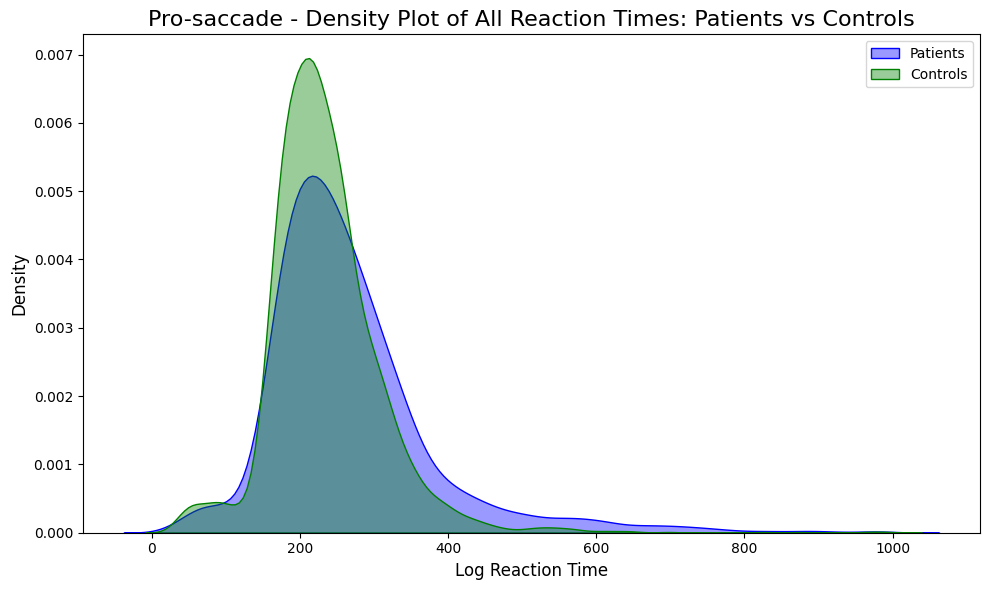

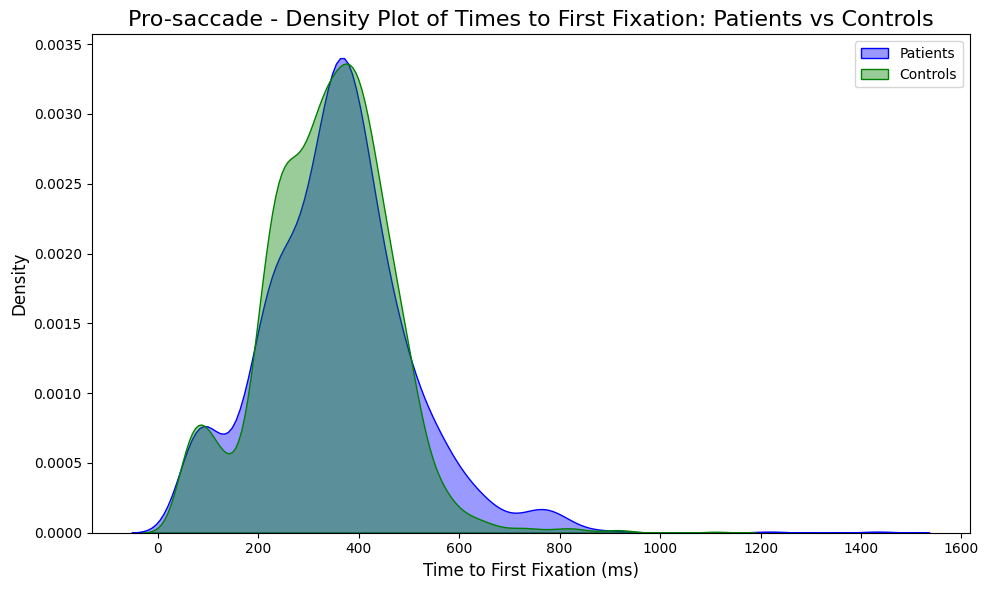

In [7]:
# Combined density plot for all reaction times
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=reaction_time_patient,
    x="reaction_time",
    color="blue",
    fill=True,
    alpha=0.4,
    label="Patients"
)
sns.kdeplot(
    data=reaction_time_control,
    x="reaction_time",
    color="green",
    fill=True,
    alpha=0.4,
    label="Controls"
)
plt.title("Pro-saccade - Density Plot of All Reaction Times: Patients vs Controls", fontsize=16)
plt.xlabel("Log Reaction Time", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Combined density plot for time to first fixation
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=first_fixation_patient,
    x="time_to_first_fixation",
    color="blue",
    fill=True,
    alpha=0.4,
    label="Patients"
)
sns.kdeplot(
    data=first_fixation_control,
    x="time_to_first_fixation",
    color="green",
    fill=True,
    alpha=0.4,
    label="Controls"
)
plt.title("Pro-saccade - Density Plot of Times to First Fixation: Patients vs Controls", fontsize=16)
plt.xlabel("Time to First Fixation (ms)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

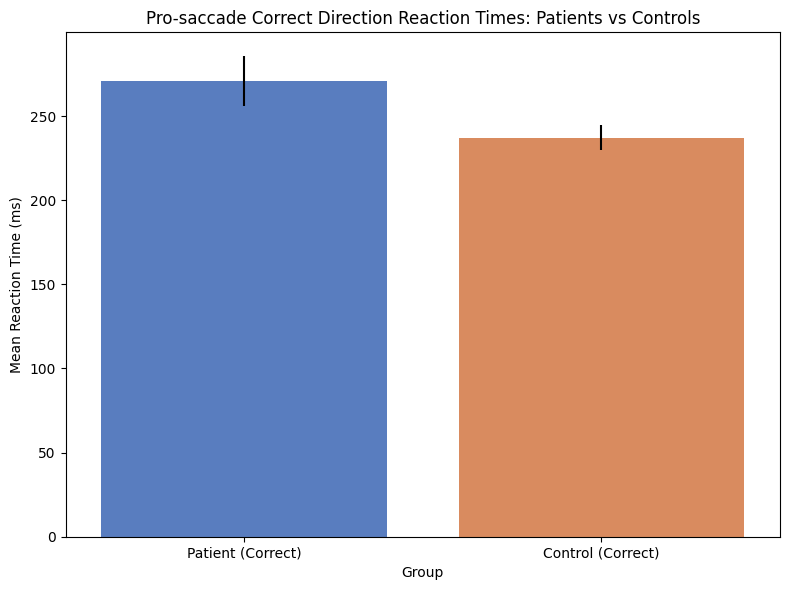

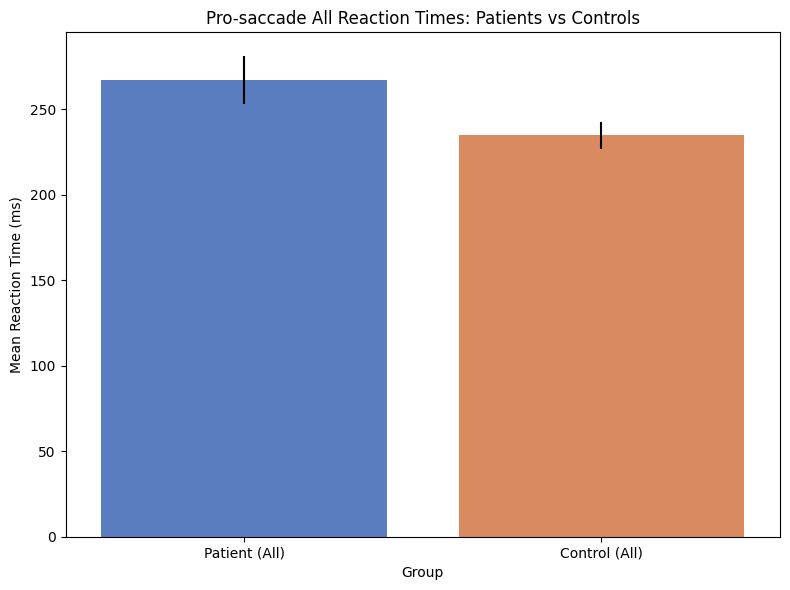

In [8]:
# Create summary statistics for reaction times
def summarize_reaction_times(df, label):
    n = df["participant_id"].nunique()  # Unique number of participants
    mean_rt = df["reaction_time"].mean()
    sd = np.std(df["reaction_time"], ddof=1)
    se_rt = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_rt": mean_rt, "sd": sd, "se_rt": se_rt}

# Summarize for the first barplot (correct reaction times)
correct_summary = pd.DataFrame([
    summarize_reaction_times(reaction_time_correct[reaction_time_correct["condition"] == "PATIENT"], "Patient (Correct)"),
    summarize_reaction_times(reaction_time_correct[reaction_time_correct["condition"] == "CONTROL"], "Control (Correct)")
])

# Summarize for the second barplot (all reaction times)
all_summary = pd.DataFrame([
    summarize_reaction_times(reaction_time[reaction_time["condition"] == "PATIENT"], "Patient (All)"),
    summarize_reaction_times(reaction_time[reaction_time["condition"] == "CONTROL"], "Control (All)")
])

# Plot the first barplot: Correct Reaction Times
plt.figure(figsize=(8, 6))
sns.barplot(
    data=correct_summary, 
    x="group", 
    y="mean_rt", 
    yerr=correct_summary["se_rt"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Correct Direction Reaction Times: Patients vs Controls")
plt.ylabel("Mean Reaction Time (ms)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

# Plot the second barplot: All Reaction Times
plt.figure(figsize=(8, 6))
sns.barplot(
    data=all_summary, 
    x="group", 
    y="mean_rt", 
    yerr=all_summary["se_rt"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade All Reaction Times: Patients vs Controls")
plt.ylabel("Mean Reaction Time (ms)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

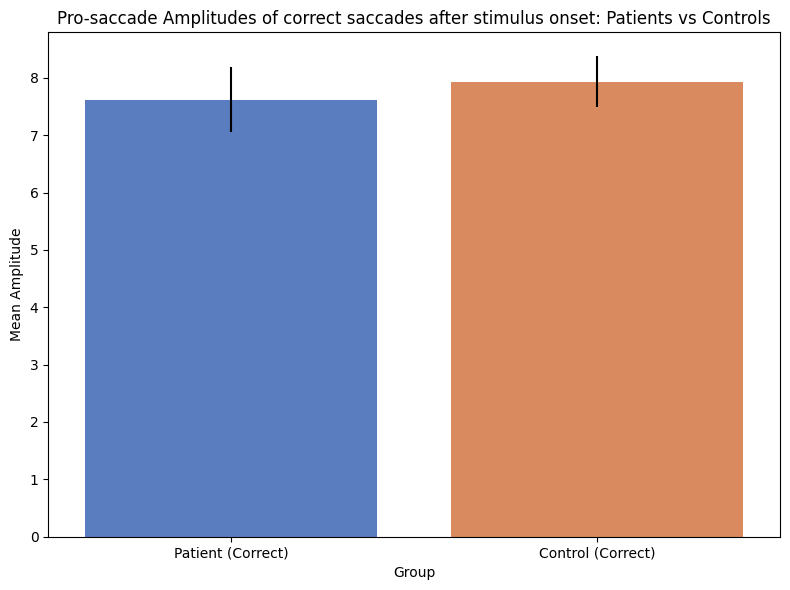

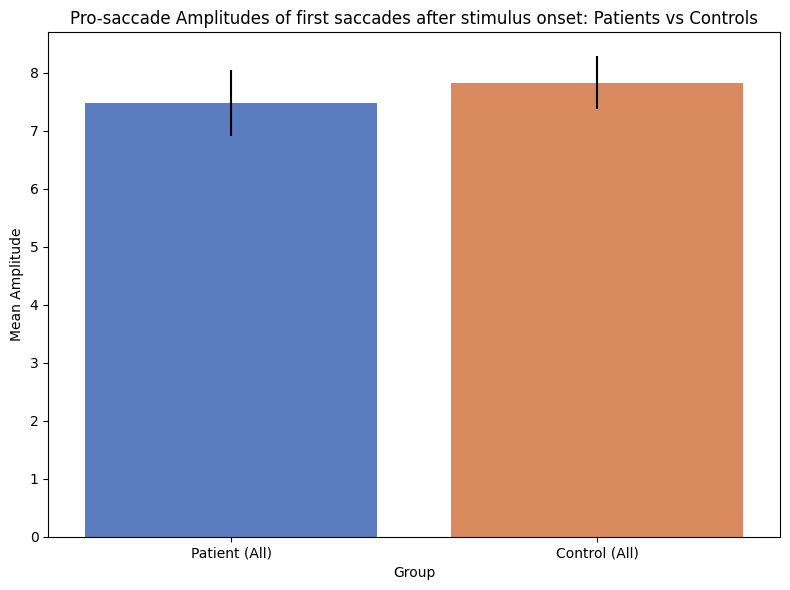

In [9]:
# Create summary statistics for amplitudes
def summarize_amplitudes(df, label):
    n = df["participant_id"].nunique()  # Unique number of participants
    mean_amp = df["amplitude"].mean()
    se_amp = np.std(df["amplitude"], ddof=1) / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_amp": mean_amp, "se_amp": se_amp}

# Summarize for the first barplot (correct amplitudes)
correct_amp_summary = pd.DataFrame([
    summarize_amplitudes(reaction_time_correct[reaction_time_correct["condition"] == "PATIENT"], "Patient (Correct)"),
    summarize_amplitudes(reaction_time_correct[reaction_time_correct["condition"] == "CONTROL"], "Control (Correct)")
])

# Summarize for the second barplot (all amplitudes)
all_amp_summary = pd.DataFrame([
    summarize_amplitudes(reaction_time[reaction_time["condition"] == "PATIENT"], "Patient (All)"),
    summarize_amplitudes(reaction_time[reaction_time["condition"] == "CONTROL"], "Control (All)")
])

# Plot the first barplot: Correct Amplitudes
plt.figure(figsize=(8, 6))
sns.barplot(
    data=correct_amp_summary, 
    x="group", 
    y="mean_amp", 
    yerr=correct_amp_summary["se_amp"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Amplitudes of correct saccades after stimulus onset: Patients vs Controls")
plt.ylabel("Mean Amplitude")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

# Plot the second barplot: All Amplitudes
plt.figure(figsize=(8, 6))
sns.barplot(
    data=all_amp_summary, 
    x="group", 
    y="mean_amp", 
    yerr=all_amp_summary["se_amp"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Amplitudes of first saccades after stimulus onset: Patients vs Controls")
plt.ylabel("Mean Amplitude")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

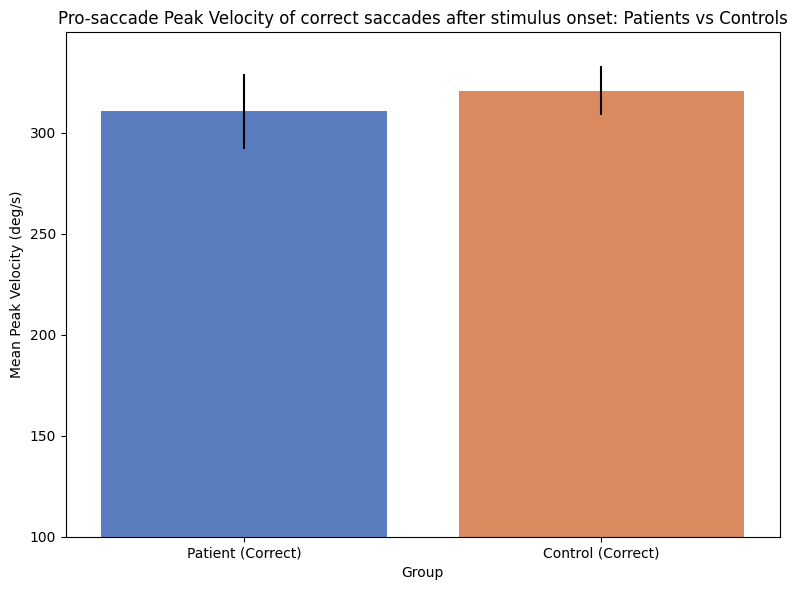

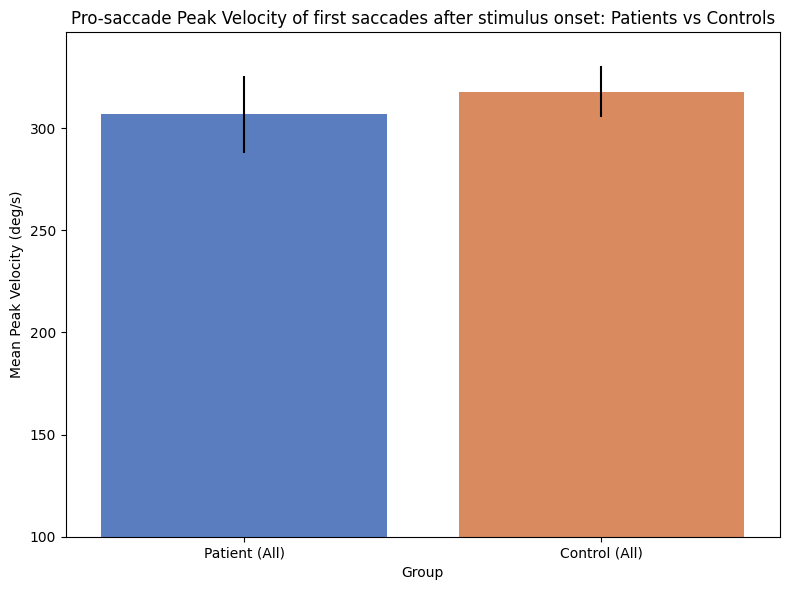

In [10]:
# Create summary statistics for peak velocity
def summarize_peak_velocity(df, label):
    n = df["participant_id"].nunique()  # Unique number of participants
    mean_peak_velocity = df["peak_velocity"].mean()
    se_peak_velocity = np.std(df["peak_velocity"], ddof=1) / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_peak_velocity": mean_peak_velocity, "se_peak_velocity": se_peak_velocity}

# Summarize for the first barplot (correct peak velocity)
correct_peak_velocity_summary = pd.DataFrame([
    summarize_peak_velocity(reaction_time_correct[reaction_time_correct["condition"] == "PATIENT"], "Patient (Correct)"),
    summarize_peak_velocity(reaction_time_correct[reaction_time_correct["condition"] == "CONTROL"], "Control (Correct)")
])

# Summarize for the second barplot (all peak velocity)
all_peak_velocity_summary = pd.DataFrame([
    summarize_peak_velocity(reaction_time[reaction_time["condition"] == "PATIENT"], "Patient (All)"),
    summarize_peak_velocity(reaction_time[reaction_time["condition"] == "CONTROL"], "Control (All)")
])

# Plot the first barplot: Correct Peak Velocity
plt.figure(figsize=(8, 6))
sns.barplot(
    data=correct_peak_velocity_summary, 
    x="group", 
    y="mean_peak_velocity", 
    yerr=correct_peak_velocity_summary["se_peak_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Peak Velocity of correct saccades after stimulus onset: Patients vs Controls")
plt.ylabel("Mean Peak Velocity (deg/s)")
plt.xlabel("Group")
plt.ylim(100, None)  # Set y-axis to start from 100
plt.tight_layout()
plt.show()

# Plot the second barplot: All Peak Velocity
plt.figure(figsize=(8, 6))
sns.barplot(
    data=all_peak_velocity_summary, 
    x="group", 
    y="mean_peak_velocity", 
    yerr=all_peak_velocity_summary["se_peak_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Peak Velocity of first saccades after stimulus onset: Patients vs Controls")
plt.ylabel("Mean Peak Velocity (deg/s)")
plt.xlabel("Group")
plt.ylim(100, None)  # Set y-axis to start from 100
plt.tight_layout()
plt.show()

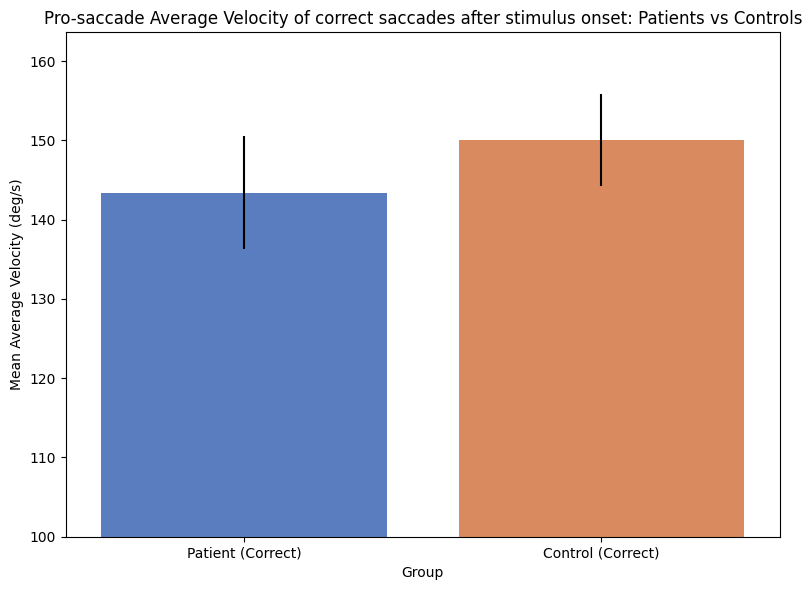

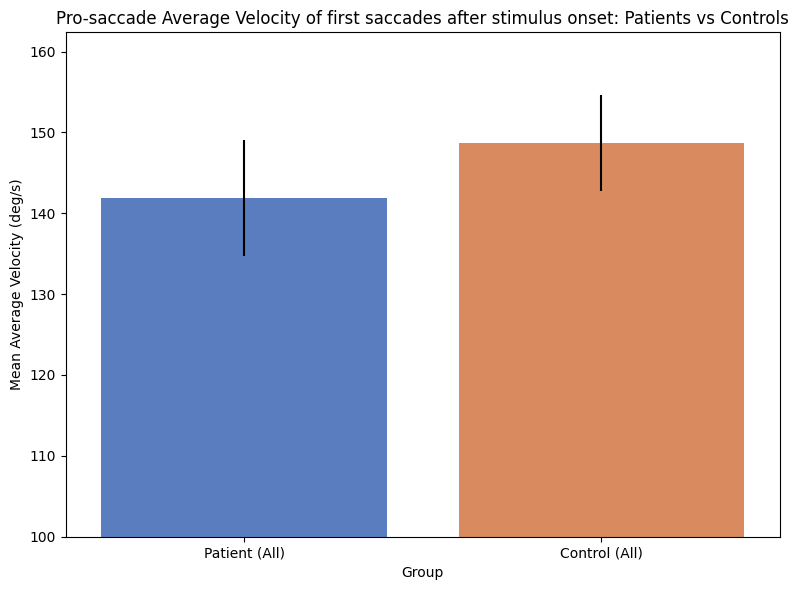

In [11]:
# Create summary statistics for average velocity
def summarize_velocity(df, label):
    n = df["participant_id"].nunique()  # Unique number of participants
    mean_velocity = df["average_velocity"].mean()
    se_velocity = np.std(df["average_velocity"], ddof=1) / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_velocity": mean_velocity, "se_velocity": se_velocity}

# Summarize for the first barplot (correct average velocity)
correct_velocity_summary = pd.DataFrame([
    summarize_velocity(reaction_time_correct[reaction_time_correct["condition"] == "PATIENT"], "Patient (Correct)"),
    summarize_velocity(reaction_time_correct[reaction_time_correct["condition"] == "CONTROL"], "Control (Correct)")
])

# Summarize for the second barplot (all average velocity)
all_velocity_summary = pd.DataFrame([
    summarize_velocity(reaction_time[reaction_time["condition"] == "PATIENT"], "Patient (All)"),
    summarize_velocity(reaction_time[reaction_time["condition"] == "CONTROL"], "Control (All)")
])

# Plot the first barplot: Correct Average Velocity
plt.figure(figsize=(8, 6))
sns.barplot(
    data=correct_velocity_summary, 
    x="group", 
    y="mean_velocity", 
    yerr=correct_velocity_summary["se_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Average Velocity of correct saccades after stimulus onset: Patients vs Controls")
plt.ylabel("Mean Average Velocity (deg/s)")
plt.xlabel("Group")
plt.ylim(100, None)  # Set y-axis to start from 100
plt.tight_layout()
plt.show()

# Plot the second barplot: All Average Velocity
plt.figure(figsize=(8, 6))
sns.barplot(
    data=all_velocity_summary, 
    x="group", 
    y="mean_velocity", 
    yerr=all_velocity_summary["se_velocity"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Average Velocity of first saccades after stimulus onset: Patients vs Controls")
plt.ylabel("Mean Average Velocity (deg/s)")
plt.xlabel("Group")
plt.ylim(100, None)  # Set y-axis to start from 100
plt.tight_layout()
plt.show()

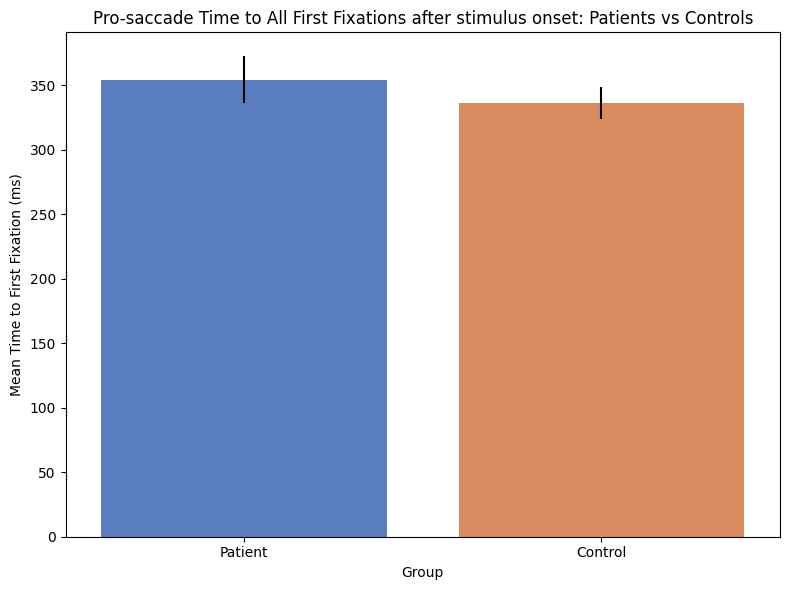

In [12]:
# Create summary statistics for time to first fixation
def summarize_time_to_first_fixation(df, label):
    n = df["participant_id"].nunique()  # Unique number of participants
    mean_time = df["time_to_first_fixation"].mean()
    sd = np.std(df["time_to_first_fixation"], ddof=1)
    se_time = sd / np.sqrt(n)  # Standard Error
    return {"group": label, "mean_time": mean_time, "sd": sd, "se_time": se_time}

# Summarize for the barplot (all time_to_first_fixation)
all_summary = pd.DataFrame([
    summarize_time_to_first_fixation(first_fixation[first_fixation["condition"] == "PATIENT"], "Patient"),
    summarize_time_to_first_fixation(first_fixation[first_fixation["condition"] == "CONTROL"], "Control")
])

# Plot the barplot: All Time to First Fixation
plt.figure(figsize=(8, 6))
sns.barplot(
    data=all_summary, 
    x="group", 
    y="mean_time", 
    yerr=all_summary["se_time"], 
    capsize=0.2, 
    palette="muted"
)
plt.title("Pro-saccade Time to All First Fixations after stimulus onset: Patients vs Controls")
plt.ylabel("Mean Time to First Fixation (ms)")
plt.xlabel("Group")
plt.tight_layout()
plt.show()

In [13]:
reaction_time

participant_id  trial_id  first_saccade_start_time  stimulus_onset_time  \
0                106         0                   1930395              1930092   
1                106         1                   1938930              1938720   
2                106         2                   1943791              1943542   
3                106         3                   1959359              1958742   
4                106         4                   1975203              1974975   
...              ...       ...                       ...                  ...   
3995             404        19                   3247266              3247064   
3996             404        20                   3263475              3263320   
3997             404        21                   3269670              3269492   
3998             404        22                   3285908              3285698   
3999             404        23                   3302932              3302745   

      start_x   end_x  end_time  duration  amplitude  peak_velocity  \
0       954.0   310.4   1930462        67      12.56          320.0   
1       972.3   942.3   1938970        40       4.62          211.0   
2       949.7  1231.2   1943839        48       5.14          286.0   
3       294.8   327.8   1959373        14       0.78           76.0   
4       959.3   909.5   1975219        16       1.03           98.0   
...       ...     ...       ...       ...        ...            ...   
3995   1012.9  1654.6   3247343        77      12.96          451.0   
3996    984.5   971.2   3263519        44       3.57          229.0   
3997    953.7  1175.5   3269718        48       5.53          293.0   
3998   1002.8  1584.1   3285970        62      11.72          406.0   
3999    975.7  1534.7   3302997        65      10.99          412.0   

      average_velocity stim_direction saccade_direction  reaction_time  \
0           187.462687      left_down         left_down            303   
1           115.500000           down         left_down            210   
2           107.083333          right          right_up            249   
3            55.714286      left_down         left_down            617   
4            64.375000      left_down         left_down            228   
...                ...            ...               ...            ...   
3995        168.311688     right_down        right_down            202   
3996         81.136364           down        right_down            155   
3997        115.208333     right_down        right_down            178   
3998        189.032258       right_up          right_up            210   
3999        169.076923     right_down        right_down            187   

     condition  
0      PATIENT  
1      PATIENT  
2      PATIENT  
3      PATIENT  
4      PATIENT  
...        ...  
3995   CONTROL  
3996   CONTROL  
3997   CONTROL  
3998   CONTROL  
3999   CONTROL  

[4000 rows x 15 columns]

In [14]:
reaction_time['log_reaction_time'] = np.log(reaction_time['reaction_time'])

In [15]:
from scipy.stats import ttest_ind

# Reaction Time: Correct
stat_reaction_correct, pval_reaction_correct = ttest_ind(
    reaction_time[reaction_time["condition"] == "PATIENT"]["log_reaction_time"], 
    reaction_time[reaction_time["condition"] == "CONTROL"]["log_reaction_time"], 
    equal_var=False
)
print(f"Reaction Time (Correct): t-statistic = {stat_reaction_correct:.4f}, p-value = {pval_reaction_correct:.4f}")

# Reaction Time: All
stat_reaction_all, pval_reaction_all = ttest_ind(
    reaction_time["log_reaction_time"][reaction_time["condition"] == "PATIENT"], 
    reaction_time["log_reaction_time"][reaction_time["condition"] == "CONTROL"], 
    equal_var=False
)
print(f"Reaction Time (All): t-statistic = {stat_reaction_all:.4f}, p-value = {pval_reaction_all:.4f}")

# Amplitude
stat_amplitude_all, pval_amplitude_all = ttest_ind(
    reaction_time["amplitude"][reaction_time["condition"] == "PATIENT"], 
    reaction_time["amplitude"][reaction_time["condition"] == "CONTROL"], 
    equal_var=False
)
print(f"Amplitude (All): t-statistic = {stat_amplitude_all:.4f}, p-value = {pval_amplitude_all:.4f}")

# Peak Velocity
stat_peak_velocity_all, pval_peak_velocity_all = ttest_ind(
    reaction_time["peak_velocity"][reaction_time["condition"] == "PATIENT"], 
    reaction_time["peak_velocity"][reaction_time["condition"] == "CONTROL"], 
    equal_var=False
)
print(f"Peak Velocity (All): t-statistic = {stat_peak_velocity_all:.4f}, p-value = {pval_peak_velocity_all:.4f}")

# Average Velocity
stat_avg_velocity_all, pval_avg_velocity_all = ttest_ind(
    reaction_time["average_velocity"][reaction_time["condition"] == "PATIENT"], 
    reaction_time["average_velocity"][reaction_time["condition"] == "CONTROL"], 
    equal_var=False
)
print(f"Average Velocity (All): t-statistic = {stat_avg_velocity_all:.4f}, p-value = {pval_avg_velocity_all:.4f}")

# Time to First Fixation
stat_time_to_fixation_all, pval_time_to_fixation_all = ttest_ind(
    first_fixation["time_to_first_fixation"][first_fixation["condition"] == "PATIENT"], 
    first_fixation["time_to_first_fixation"][first_fixation["condition"] == "CONTROL"], 
    equal_var=False
)
print(f"Time to First Fixation (All): t-statistic = {stat_time_to_fixation_all:.4f}, p-value = {pval_time_to_fixation_all:.4f}")

Reaction Time (Correct): t-statistic = 8.5583, p-value = 0.0000
Reaction Time (All): t-statistic = 8.5583, p-value = 0.0000
Amplitude (All): t-statistic = -2.3639, p-value = 0.0181
Peak Velocity (All): t-statistic = -2.4017, p-value = 0.0164
Average Velocity (All): t-statistic = -3.5812, p-value = 0.0003
Time to First Fixation (All): t-statistic = 3.8027, p-value = 0.0001
